In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt

In [2]:
current_directory = os.getcwd()
print(current_directory)
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

D:\boshi\GitHub\kears_learning\training_project\Natural Language Processing with Disaster Tweets


In [3]:
print(train.columns)
train.head(5)

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
train_label = train.target.to_numpy()

In [6]:
y_train = train_label.reshape(-1)

In [7]:
train.drop(['id', 'keyword', 'location', 'target'], axis=1, inplace=True)
test.drop(['id', 'keyword', 'location'], axis=1, inplace=True)

In [8]:
train = train.to_numpy()
test = test.to_numpy()
X_train = train.reshape(-1)
X_test = test.reshape(-1)

In [9]:
print(X_train[0])

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all


## Normalization

In [10]:
import re
import string

def clean_tweet(tweet):

  #apostrophe
  tweet = re.sub(r'\x89Ûª', "'", tweet)
  tweet = re.sub(r'\x89Û÷', "'", tweet)

  #quotation
  tweet = re.sub(r'\x89ÛÏ', '"', tweet)
  tweet = re.sub(r'\x89Û\x9d', '"', tweet)

  #hyphen
  tweet = re.sub(r'\x89ÛÒ', '-', tweet)
  tweet = re.sub(r'\x89ÛÓ', '—', tweet)

  #euro
  tweet = re.sub(r'\x89âÂ', '€', tweet)

  #ellipsis
  tweet = re.sub(r'\x89Û_', '...', tweet)

  #amp
  tweet = re.sub(r'&', 'and', tweet)


  #bullet
  tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
  tweet = re.sub(r'\x89Û¢', '', tweet)


  #no idea
  tweet = re.sub(r'\x89ã¢', '', tweet)
  tweet = re.sub(r"å_", "", tweet)


  #other
  tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
  tweet = re.sub(r"åÊ", "", tweet)
  tweet = re.sub(r"åÈ", "", tweet)
  tweet = re.sub(r"JapÌ_n", "Japan", tweet)
  tweet = re.sub(r"Ì©", "e", tweet)
  tweet = re.sub(r"å¨", "", tweet)
  tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
  tweet = re.sub(r"åÇ", "", tweet)
  tweet = re.sub(r"å£3million", "3 million ", tweet)
  tweet = re.sub(r"åÀ", "", tweet)

  return tweet

def find_URL(text):
  url = re.compile(r'https?://\S+|www\.\S+')

  return url.findall(text)

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'This is a website.',text)

def remove_html(text):
  html=re.compile(r'<.*?>')
  return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)



In [11]:
def custom_standardization(input_data):
    r = clean_tweet(input_data)
    r = remove_URL(r)
    r = remove_html(r)
    r = remove_emoji(r)
    r = str.lower(r)
    return r

In [12]:
all_tweets = np.append(X_train, X_test)
def normalization(tweets):
    result = []
    for tweet in tweets:
        result.append(custom_standardization(tweet))
    return result

all_tweets = normalization(all_tweets)

In [13]:
# Model constants.
max_features = 20000
embedding_dim = 128
max_len = 500

In [14]:
from keras.layers import *
vectorize_layer = TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=max_len)

## Let's make a text-only dataset (no labels):

In [15]:
# Let's call `adapt`:
vectorize_layer.adapt(all_tweets)

## Apply it to the text dataset

In [16]:
import tensorflow as tf
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [17]:
from keras.metrics import AUC
from keras import optimizers, losses
def build_model():

    text_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')
    x = vectorize_layer(text_input)
    x = Embedding(max_features + 1, embedding_dim)(x)
    x = Dropout(0.5)(x)

    x1 = Bidirectional(LSTM(units=128, return_sequences=True))(x)
    x2 = Bidirectional(LSTM(units=64, return_sequences=True))(x1)

    z2 = Bidirectional(GRU(units=128, return_sequences=True))(x)
    z3 = Bidirectional(GRU(units=64, return_sequences=True))(z2)
    c = Concatenate(axis=2)([x2, z3])

    x3 = Bidirectional(LSTM(units=128, return_sequences=True))(c)
    # Conv1D + global max pooling

    x = GlobalMaxPooling1D()(x3)

    # We add a vanilla hidden layer:
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.5)(x)

    # We project onto a single unit output layer, and squash it with a sigmoid:
    predictions = Dense(1, activation="sigmoid", name="predictions")(x)

    model = tf.keras.Model(text_input, predictions)

    # Compile the model with binary crossentropy loss and an adam optimizer.

    model.compile(loss=losses.binary_crossentropy, optimizer=optimizers.rmsprop_v2.RMSprop(learning_rate=0.0001), metrics=[AUC(name = 'auc')])
    return model

In [18]:
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 500)         0           ['text[0][0]']                   
 ization)                                                                                         
                                                                                                  
 embedding (Embedding)          (None, 500, 128)     2560128     ['text_vectorization[0][0]']     
                                                                                                  
 dropout (Dropout)              (None, 500, 128)     0           ['embedding[0][0]']          

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [20]:
from keras.callbacks import *

lr = ReduceLROnPlateau(monitor="val_auc", mode='max', factor=0.7, patience=4, verbose=False)
es = EarlyStopping(monitor='val_auc',mode='max', patience=10, verbose=False,restore_best_weights=True)

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=60, batch_size=128,
                    callbacks=[es,lr])

Epoch 1/60
48/48 [==============================] - 26s 310ms/step - loss: 0.6851 - auc: 0.5091 - val_loss: 0.6824 - val_auc: 0.5941 - lr: 1.0000e-04
Epoch 2/60
48/48 [==============================] - 13s 262ms/step - loss: 0.6804 - auc: 0.5572 - val_loss: 0.6760 - val_auc: 0.7526 - lr: 1.0000e-04
Epoch 3/60
48/48 [==============================] - 13s 267ms/step - loss: 0.6411 - auc: 0.7025 - val_loss: 0.5873 - val_auc: 0.7906 - lr: 1.0000e-04
Epoch 4/60
48/48 [==============================] - 13s 267ms/step - loss: 0.5504 - auc: 0.7846 - val_loss: 0.5171 - val_auc: 0.8158 - lr: 1.0000e-04
Epoch 5/60
48/48 [==============================] - 13s 265ms/step - loss: 0.5007 - auc: 0.8212 - val_loss: 0.4880 - val_auc: 0.8314 - lr: 1.0000e-04
Epoch 6/60
48/48 [==============================] - 13s 267ms/step - loss: 0.4616 - auc: 0.8487 - val_loss: 0.4808 - val_auc: 0.8401 - lr: 1.0000e-04
Epoch 7/60
48/48 [==============================] - 13s 268ms/step - loss: 0.4323 - auc: 0.8660 - va

In [21]:
def plot_hist(hist, metric='auc'):
    plt.plot(hist.history[metric])
    plt.plot(hist.history["val_" + metric])
    plt.title(f"model performance")
    plt.ylabel("area_under_curve")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
    return


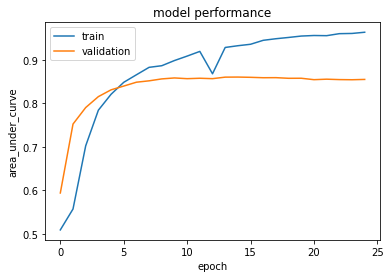

In [22]:
plot_hist(hist=history)

In [23]:
y_pred = model.predict(X_test).squeeze()

In [24]:
y_pred

array([0.79912233, 0.46299836, 0.9720544 , ..., 0.9474479 , 0.9189915 ,
       0.4546483 ], dtype=float32)

In [25]:
sub_data = pd.read_csv("data/sample_submission.csv")

In [26]:
sub_data

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [27]:
sub_data.target = (y_pred > 0.5).astype(int)

In [28]:
sub_data

,id,target
0,0,1
1,2,0
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [29]:
sub_data.to_csv('submission.csv', index=False)